# "Quora Question Pairs"
> "Given two questions from quora, We have to find how similar are they?."

- toc: false
- branch: master
- badges: true
- comments: true
- author: Sai Kumar Reddy Pochireddygari
- categories: [Python, Machine Learning, Statistics, EDA, Data Science]

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

credits:kaggle

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not.

<h3> 1.3 Source/Useful Links <h3>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [0]:
!pip install fuzzywuzzy


### Importing required libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly 
import math
import string
import re
import nltk
from nltk import SnowballStemmer , PorterStemmer
import collections 
from bs4 import BeautifulSoup
from wordcloud import STOPWORDS
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss , confusion_matrix 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



<h5> Loading Dataset<h5>

In [0]:
df=pd.read_csv("/content/drive/My Drive/train.csv")


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
df

id  ...  is_duplicate
0            0  ...             0
1            1  ...             0
2            2  ...             0
3            3  ...             0
4            4  ...             0
...        ...  ...           ...
404285  404285  ...             0
404286  404286  ...             1
404287  404287  ...             0
404288  404288  ...             0
404289  404289  ...             0

[404290 rows x 6 columns]

In [0]:
df.shape

(404290, 6)

In [0]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

<p>
The columns present in the data set are id, qid1 , qid2, question1 , question2 , is_duplicate.
So, our dependent Vars are qid1 , qid2, question1 , question2 and indepent var/Target var is is_duplicate
<p>


<p>
Before proceeding for any thing , I have to check for NaN values because they cause some problem and they should be handled.
<p>

In [0]:
df[df.isna().any(1)]

id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]

<p>
As we can there are three questions that has NaN values. I need to replace them with something , better go for replacing them with emtpy strings 
<p>

In [0]:
df=df.fillna(value=" ")

<p>
Lets check the changes, and find if we can see any other NaN values
<p>

In [0]:
df[df.isna().any(1)]

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

In [0]:
df

id  ...  is_duplicate
0            0  ...             0
1            1  ...             0
2            2  ...             0
3            3  ...             0
4            4  ...             0
...        ...  ...           ...
404285  404285  ...             0
404286  404286  ...             1
404287  404287  ...             0
404288  404288  ...             0
404289  404289  ...             0

[404290 rows x 6 columns]

<h2> 3.1 Basic questions on Dataset / distribution of datapoints with respect to class labels<h2>

<h3>Q1: How is the class label ( is_duplicate ) distributed with respect to data points?<h3>

In [0]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

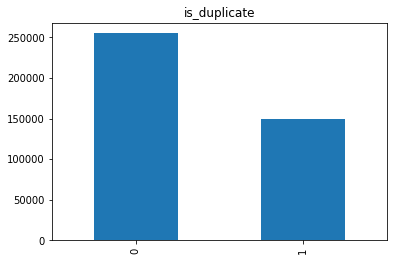

In [0]:
df.is_duplicate.value_counts().plot.bar()
plt.title("is_duplicate")
plt.show()

<p>
As we can see we have fairly unbalanced dataset, for is_duplicate = 0 we have 255027 data points and for is_duplicate = 1 we have 149263 data points 
<p>

<h3>Q2.Are these questions repeating multiple times?  <h3>
<p>
Simply by Logic to repeat multiple times there should be two or more other data points with same 'qid1', 'qid2', 'question1', 'question2' , 'is_duplicate'

so , i can drop these data.
<p>

In [0]:
final_df=df.drop_duplicates(subset={'qid1','qid2','question1','question2','is_duplicate'}, keep='first', inplace=False)

In [0]:
final_df.shape

(404290, 6)

In [0]:
# Intial DF
df.shape

(404290, 6)

<p>
As we can see there were no duplicates in the data set by seeing the intial df size and after removing duplicates the df size.
<p>

<h3> Q3.Can we see unique questions and repeated questions ?<h3>

<p>we can know them by looking at Question Id's<p>

In [0]:
x_total_questions = df.qid1.values.tolist() + df.qid2.values.tolist()

In [0]:
y_repeated_questions=pd.DataFrame(x_total_questions)

In [0]:
# These are the total questions in data set with repeations
total_questions_in_dataFrame=len(x_total_questions)

In [0]:
# these are the unique questions 
totalnumber_of_unique_questions = len(set(x_total_questions))

In [0]:
# these are no of questions appreared more than one time
noof_questions_appeared_morethanonetime = np.sum((y_repeated_questions[0].value_counts()>1))

In [0]:
y_repeated_questions
type(y_repeated_questions)

pandas.core.frame.DataFrame

In [0]:
print("the total no of questions in Dataframe is {0} , the total no of unique questions in data frame is {1} and \nthe number of questions repeated more than one time is  {2}".format(total_questions_in_dataFrame,totalnumber_of_unique_questions,noof_questions_appeared_morethanonetime))

the total no of questions in Dataframe is 808580 , the total no of unique questions in data frame is 537933 and 
the number of questions repeated more than one time is  111780


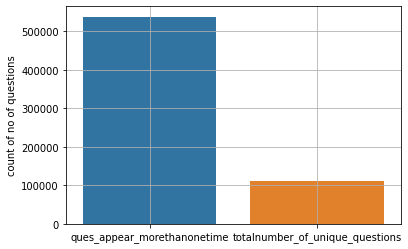

In [0]:
#plotting the above 
x=["ques_appear_morethanonetime","totalnumber_of_unique_questions"]
y=[totalnumber_of_unique_questions,noof_questions_appeared_morethanonetime]
sns.barplot( x,y)
plt.ylabel("count of no of questions")
plt.grid("white")
plt.show()

<p> As we can see there are more no of questions that appeared more than once 

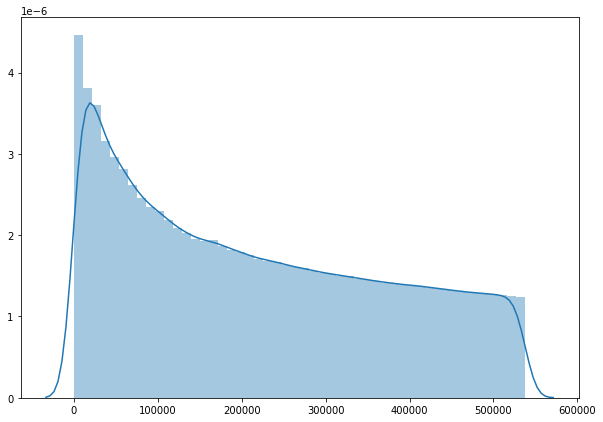

In [0]:
#plt.hist( , data=noof_questions_appeared_morethanonetime)
plt.figure(figsize=(10,7))
sns.distplot(y_repeated_questions)
plt.show()

<h>

<P> As we answered the questions lets go to the featurisations part to get insights about data and see if it can help in out objective of classification or not. <P>

<h2>3.2 Fearisation to get more insights about the data that help in  objective of classification  <h2>

*As our data set is having question1 and question2 features just by looking at these we cannot make sense as we cannot plot them as they are actual questions itself and by logic we know that if two questions are different then there will/will not be different/not different words with or without the semantic meanings of the words everything depends on the context. As we are humans reading the pair of questions it will be easy to understand for us and differentiate .For a machine to differentiate means it needs data in machine readable form that is numbers.*
Here  in this part we will create some own features based on the questions we have with out cleaning the questions and preproccesing them and perform **EDA**
on them ,Later we can convert sentances and create advance features and do **EDA** on them as well to know these features are helpful or not.

**Defining these Features** :--- 
<p>

*   no_words_in_question1 :-  total words in question1
*   no_words_in_question2 :-  total words in question2
*   len_of_question1 :-  length of the question1
*   len_of_question2 :-  length of the question2 
*   unique_commonwords_inboth_qestions :-  total common words which are unique to both questions

*   frequency_of_question1 :- no of times this question1 occurs 
*   frequency_of_question2 :- no of times this question2 occurs 
*   word_share  :- this is basically words shared between two sentances,uniquecmmnwords q1+q2/totalnoofwordsin q1+q2
*   freq1+freq2 :- freqency of q1 + freq q2
*   freq1-freq2 :- abs(frequency of q1 - freq q2)
*   total_noof_words_q1+q2 :- no of words in question1+question2



<p>


In [0]:
# creating functions for these features

def noWordsInQuestion1(data):
  '''
  This function is used to take a element  and compute the no of words in each element
  '''

  return (len((data).split(" ")))


def noWordsInQuestion2(data):
  '''
  This function is used to take a element and compute the no of words in each element
  '''

  return (len((data).split(" ")))

def lengthOfQuestion1(data):
  '''
  This Function is used to compute the length of the element
  '''
  return len(data)

def lengthOfQuestion2(data)  :
  '''
  This Function is used to compute the length of the element
  '''
  return len(data)

def uniqueCommonWordsInBothQestions(data):
  '''
  This Dunction is used to compute the Total common words shared between two questions
  '''
  
  q1=data['question1']
  q2=data['question2']

  q1_words=(set(q1.split(" ")))
  q2_words=(set(q2.split(" ")))
  
  return len((q1_words.intersection(q2_words)))

def wordShare(data):
  '''
  This function is used to caluculate the wordshare
  '''

  q1=data['question1']
  q2=data['question2']

  q1_words=(set(q1.split(" ")))
  q2_words=(set(q2.split(" ")))
  length_numerator=len((q1_words.intersection(q2_words)))
  
  q1_words_length=len(q1.split(" "))
  q2_words_length=len(q2.split(" "))
  length_denominator=q1_words_length + q2_words_length
  
  total=length_numerator/length_denominator
  return total



#### *applying the functions  to the dataset 

In [0]:
df['no_words_in_question1']=df['question1'].apply(noWordsInQuestion1)
df['no_words_in_question2']=df['question2'].apply(noWordsInQuestion2)
df['len_of_question1']=df['question1'].apply(lengthOfQuestion1)
df['len_of_question2']=df['question2'].apply(lengthOfQuestion2)
df['commonUniqueWords_inBothQuestions']=df.apply(uniqueCommonWordsInBothQestions , axis=1)
df['frequency_of_question1'] = df.groupby('qid1')['qid1'].transform('count')
df['frequency_of_question2'] = df.groupby('qid2')['qid2'].transform('count')
df['wordshare']=df.apply(wordShare , axis=1)
df['fq1+fq2']=df['frequency_of_question1']+df['frequency_of_question2']
df['fq1-fq2']=abs(df['frequency_of_question1']-df['frequency_of_question2'])
df['total_no_of_words_q1+q2']=df['no_words_in_question1']+df['no_words_in_question2']

In [0]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'no_words_in_question1', 'no_words_in_question2', 'len_of_question1',
       'len_of_question2', 'commonUniqueWords_inBothQuestions',
       'frequency_of_question1', 'frequency_of_question2', 'wordshare',
       'fq1+fq2', 'fq1-fq2', 'total_no_of_words_q1+q2'],
      dtype='object')

<p>
As we have added extra features lets do EDA on them and check if they justify to our objective 
<p>

<h3> 3.2.1 EDA on Basic Features Created<h3>

In [0]:
dnew_eda=df[['no_words_in_question1','no_words_in_question2','len_of_question1',
       'len_of_question2', 'commonUniqueWords_inBothQuestions',
       'frequency_of_question1', 'frequency_of_question2', 'wordshare',
       'fq1+fq2', 'fq1-fq2', 'total_no_of_words_q1+q2','is_duplicate']]

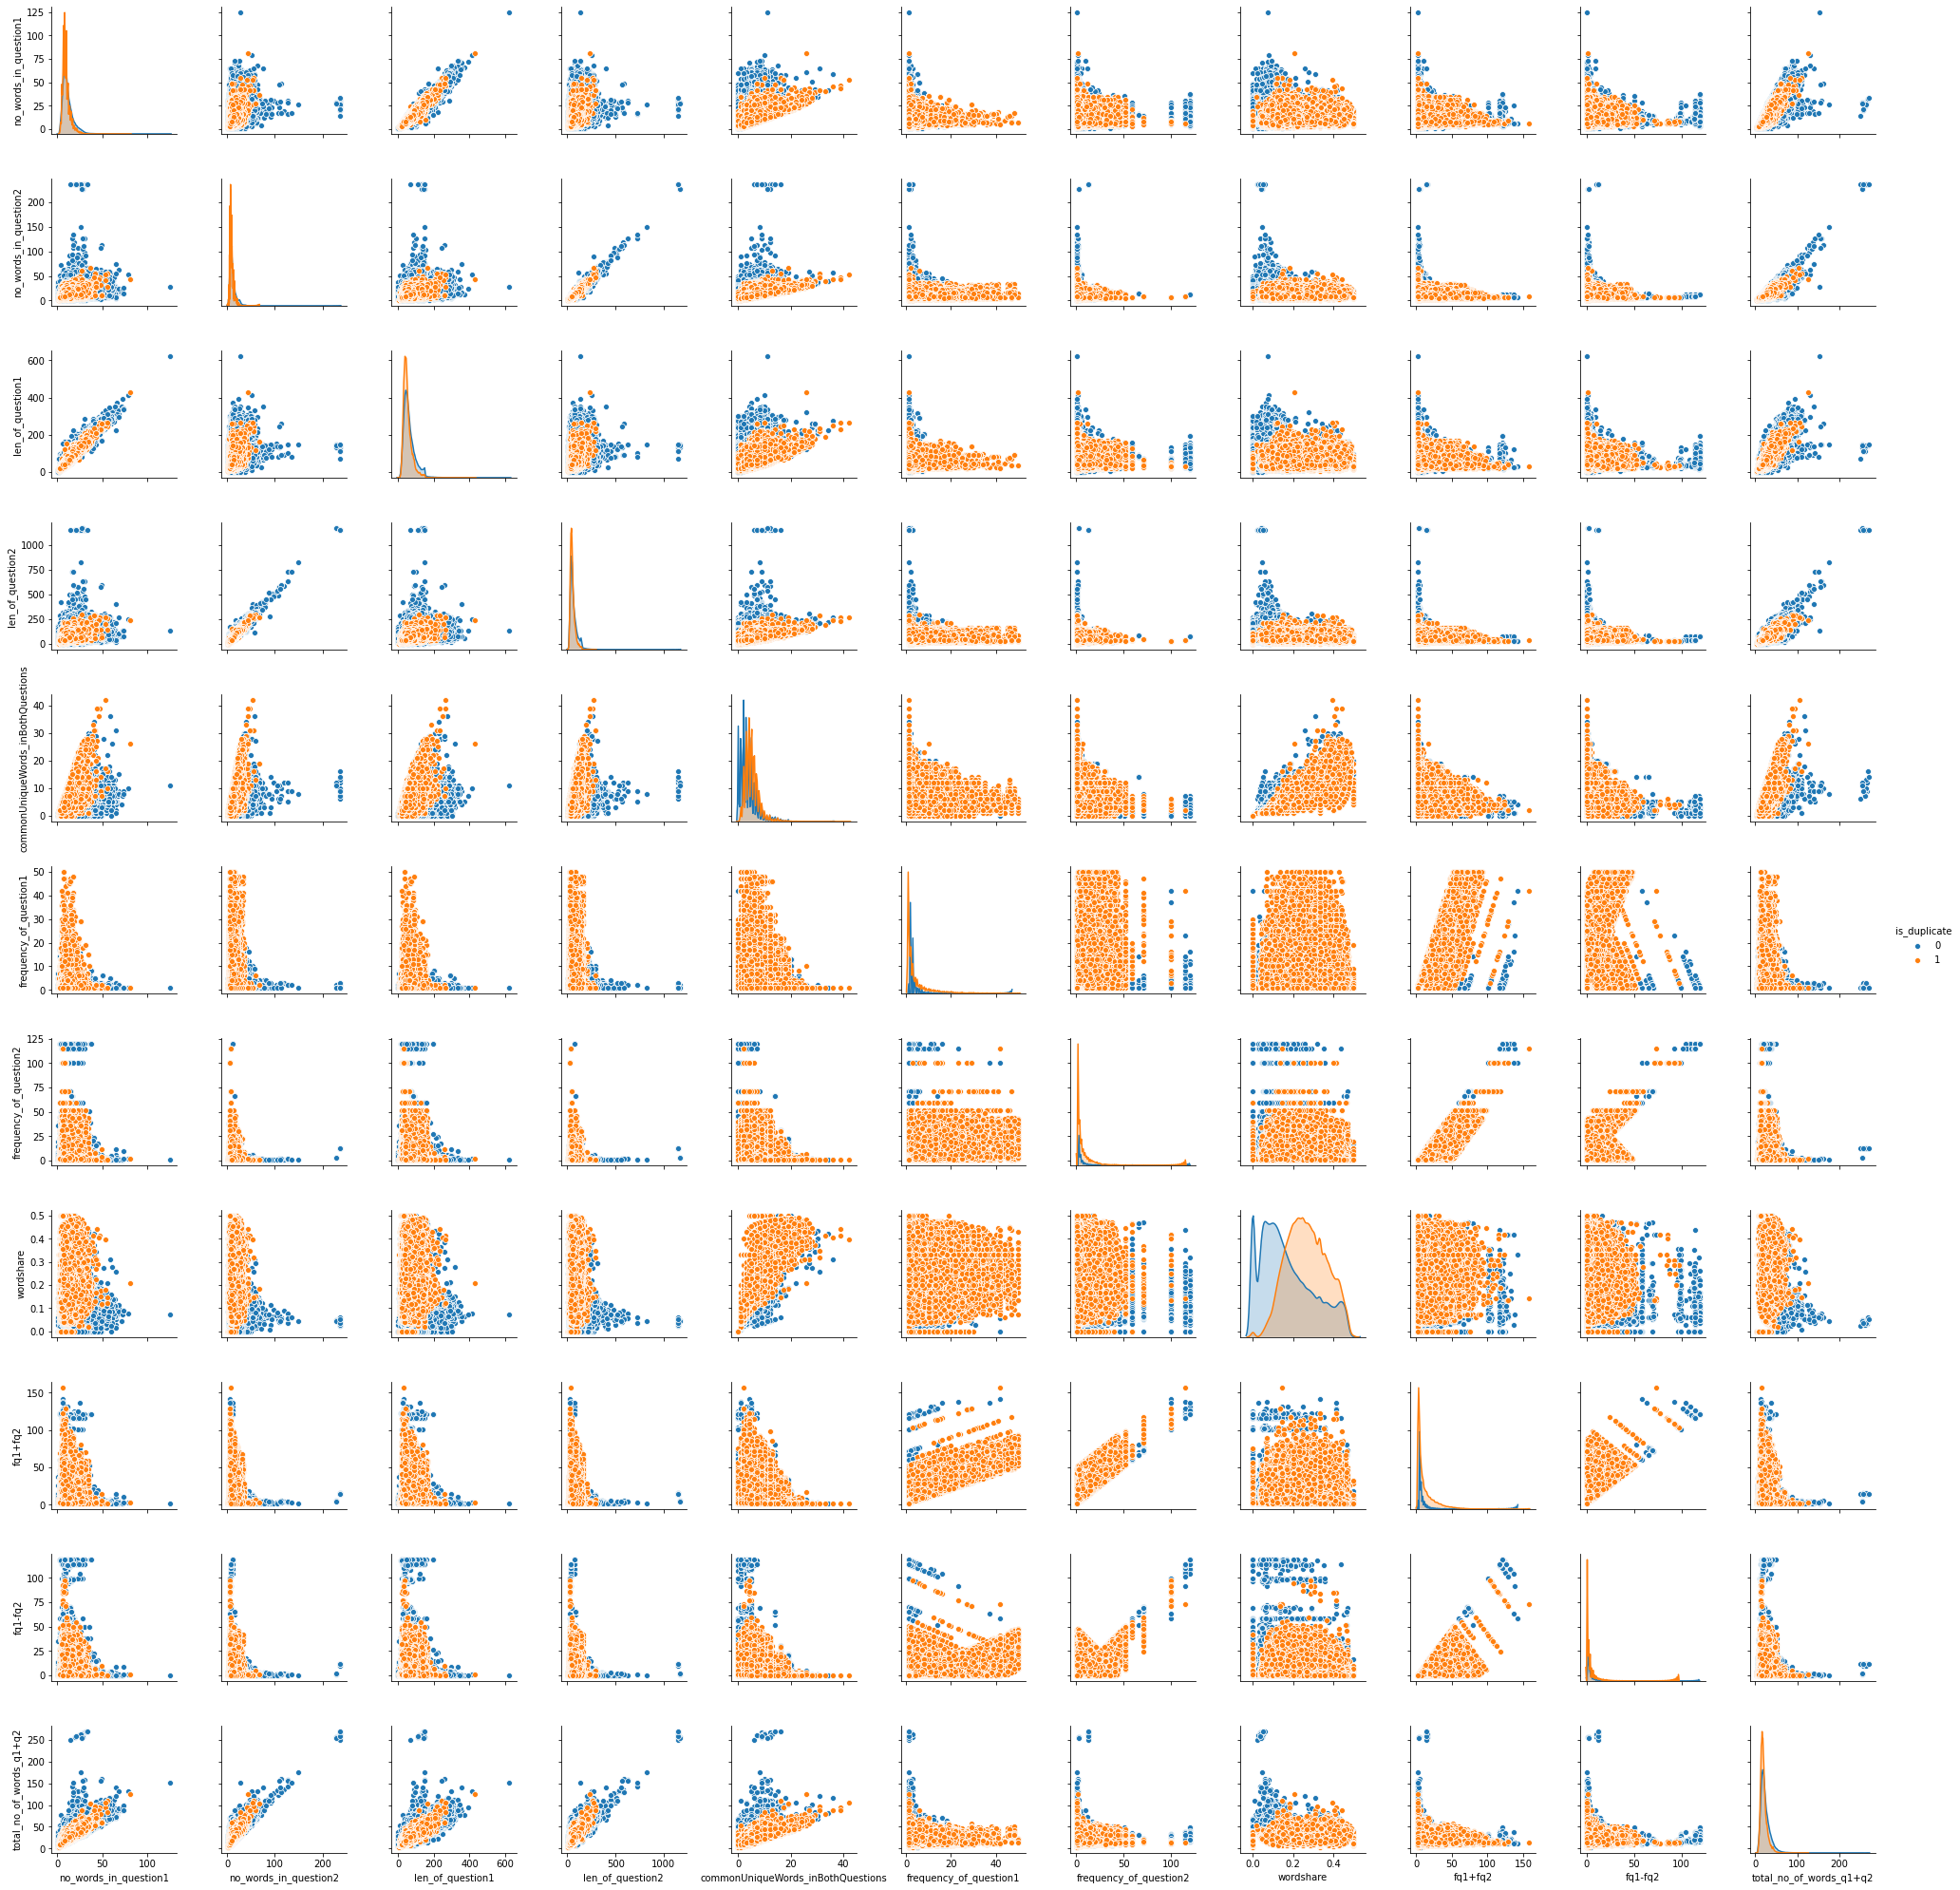

In [0]:
sns.pairplot(dnew_eda,hue='is_duplicate')
plt.show()

<p>by looking at above observations i can see word share and common words are performing good, " word share and common unique words " than others lets plot these features for pdfs , and histograms<p>

<h3>3.2.2 Univariate Analysis and Bi variate Analysis<h3>

 *By Looking at the previous plots we came to conclusion that word share and common unique words are the two features that help towards our objective at hand comparitively than other features*
 
Lets perform univariate analysis on them.

<h5> Univariate Analysis :  <h5>


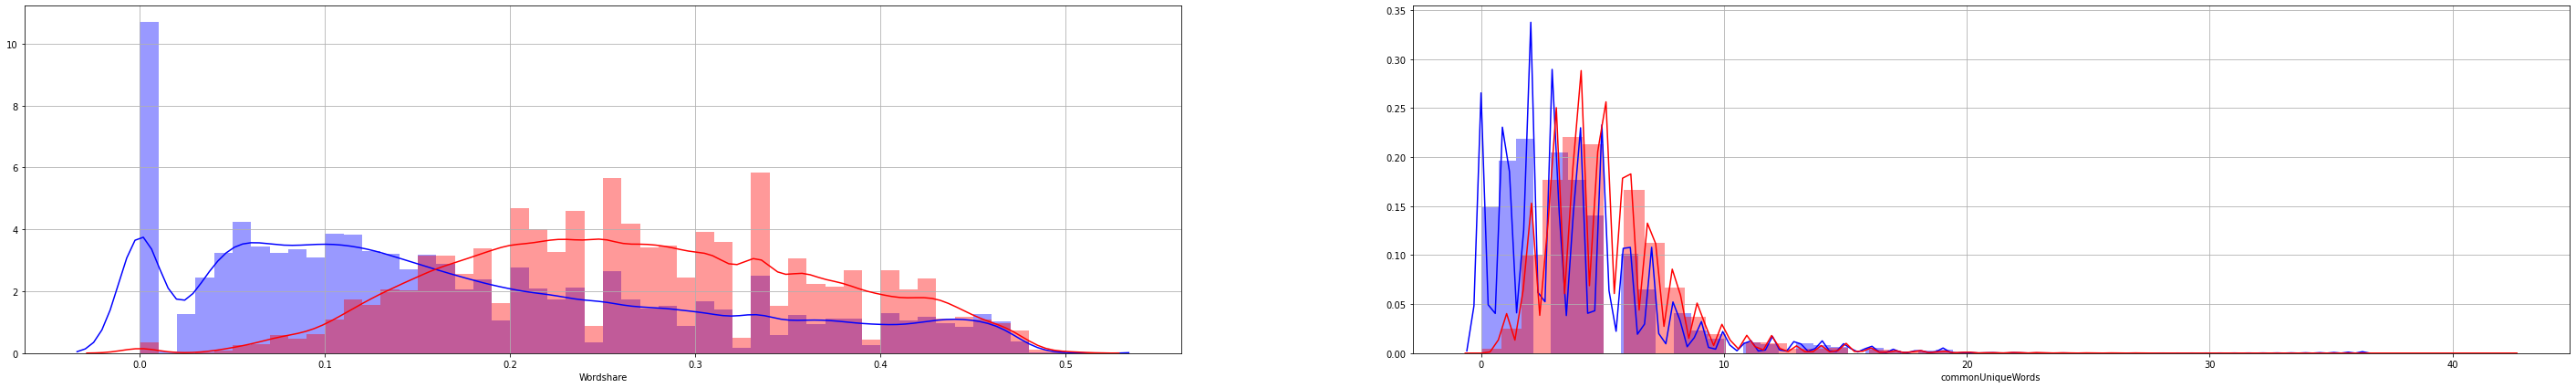

In [0]:

plt.figure(1 ,figsize=(50,7))
plt.subplot(1,2,1  )
sns.distplot(df[df['is_duplicate']== 0.0]['wordshare'],color='blue' , bins = 50)
sns.distplot(df[df['is_duplicate']==1.0]['wordshare'] ,color='red',bins = 50)
plt.xlabel('Wordshare')
plt.grid('white')

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']== 0.0]['commonUniqueWords_inBothQuestions'],color='blue', bins = 50)
sns.distplot(df[df['is_duplicate']== 1.0]['commonUniqueWords_inBothQuestions'],color='red', bins = 50)
plt.grid('White')
plt.xlabel('commonUniqueWords')

plt.show()

* There is some sort of seperation in  intial  part of the graph, so we can say that these two new features are usefull to some extent in our objective of classification.

<h5> BiVariable Analysis :  <h5>

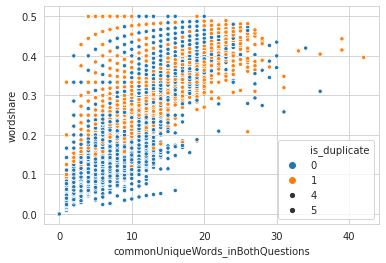

In [0]:
sns.set_style('whitegrid')
sns.scatterplot(data=df,y='wordshare',x='commonUniqueWords_inBothQuestions',size=5,hue='is_duplicate')
plt.show()

* <p>As you can see by scatterplot above we can conclude that there is atleast  some seperation of is_duplicate=0 and is_dulicate=1 points so this two features are helpful in our objective of classification.<p>  

* As the EDA part is done lets go to data cleaning part so that after cleaning we can create advance features and perform analyzing

* Lets add some advanced Features in to our dataset

<h4>3.2.2 Advaced Features <h4>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>







<p>lets write functions to acheive the features we need<p>

In [0]:
# token:- when we split by space we get token words
# word :- which is a token and not a stop word
# stop words :- stopwords

def cwc_min_ratio(data):
  '''
  This function is used to caluculate ratio common word count to min (len(q1),len(q2)) given two questions
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  words_q1=q1_words.split(" ")
  words_q2 = q2_words.split(" ")
  
  w_q1=[ word for word in words_q1 if word not in STOPWORDS]
  w_q2=[ word for word in words_q2 if word not in STOPWORDS]

  cwc_numerator= len((set(w_q1)).intersection(set(w_q2)))
  cwc_denominator = (min(len(w_q1), len(w_q2)) +0.0001)

  return (cwc_numerator / cwc_denominator )

def cwc_max_ratio(data):
  '''
  This function is used to caluculate ratio common word count to max (len(q1),len(q2)) given two questions
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  words_q1=q1_words.split(" ")
  words_q2 = q2_words.split(" ")
  
  w_q1=[ word for word in words_q1 if word not in STOPWORDS]
  w_q2=[ word for word in words_q2 if word not in STOPWORDS]

  cwc_numerator= len((set(w_q1)).intersection(set(w_q2)))
  cwc_denominator = (max(len(w_q1), len(w_q2)) + +0.0001)

  return (cwc_numerator / cwc_denominator )

def ctc_min_ratio(data):
  '''
  THis function is used to caluculate the ratio of common tokens to min( len(q1),len(q2) )
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  tokens_q1=q1_words.split(" ")
  tokens_q2 = q2_words.split(" ")    
  
  t_q1= set(tokens_q1)
  t_q2=set(tokens_q2)

  ctc_numerator = len(t_q1.intersection(t_q2))
  ctc_denominator= (min(len(tokens_q1),len(tokens_q2)) +0.0001)

  return (ctc_numerator/ ctc_denominator )

def ctc_max_ratio(data):
  '''
  THis function is used to caluculate the ratio of common tokens to max( len(q1),len(q2) )
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  tokens_q1=q1_words.split(" ")
  tokens_q2 = q2_words.split(" ")
  
  t_q1= set(tokens_q1)
  t_q2=set(tokens_q2)

  ctc_numerator = len(t_q1.intersection(t_q2))
  ctc_denominator= (max(len(tokens_q1),len(tokens_q2))   +0.0001)

  return (ctc_numerator / ctc_denominator)

def csc_min_ratio(data):
  '''
  This function is used to caluculate ratio common stop word count to min (len(q1),len(q2)) given two questions
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  words_q1=q1_words.split(" ")
  words_q2 = q2_words.split(" ")
  
  stopwords_q1=[ word for word in words_q1 if word  in STOPWORDS]
  stopwords_q2=[ word for word in words_q2 if word  in STOPWORDS]

  csc_numerator= len((set(stopwords_q1)).intersection(set(stopwords_q2)))
  csc_denominator = ((min(len(stopwords_q1), len(stopwords_q2))) +0.0001)

  return (csc_numerator / csc_denominator )

def csc_max_ratio(data):
  '''
  This function is used to caluculate ratio common stop word count to max (len(q1),len(q2)) given two questions
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  words_q1=q1_words.split(" ")
  words_q2 = q2_words.split(" ")
  
  stopwords_q1=[ word for word in words_q1 if word  in STOPWORDS]
  stopwords_q2=[ word for word in words_q2 if word  in STOPWORDS]

  csc_numerator= len((set(stopwords_q1)).intersection(set(stopwords_q2)))
  csc_denominator = (max(len(stopwords_q1), len(stopwords_q2)) +0.0001)

  return (csc_numerator / csc_denominator )

def lastWordEqual(data):
  '''
  This function is used to compareLast words of two pair of questions and return 1 or 0
  '''
  q_1=data['question1']
  q_2=data['question2']

  q_1_words=q_1.split(" ")
  q_2_words=q_2.split(" ")

  if q_1_words[-1] == q_2_words[-1]:
    return (1)
  else:
    return (0)


def firstWordEqual(data):
  '''
  This function is used to compareFirst words of two pair of questions and return 1 or 0
  '''
  q_1=data['question1']
  q_2=data['question2']

  q_1_words=q_1.split(" ")
  q_2_words=q_2.split(" ")

  if q_1_words[0] == q_2_words[0]:
    return (1)
  else:
    return (0)

def tokenLengthDIff(data):
  '''
  This function is used to caluculate the ABS diff of len(q1_tokes) and len (Q2_tokens)
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  tokens_q1=q1_words.split(" ")
  tokens_q2 = q2_words.split(" ")
  diff=abs(len(tokens_q1)- len(tokens_q2))
  return (diff )

def tokenLengthAvg(data):
  '''
  This function is used to caluculate the avg of len(q1_tokes) and len (Q2_tokens)
  '''
  q1_words=data['question1']
  q2_words=data['question2']

  tokens_q1=q1_words.split(" ")
  tokens_q2 = q2_words.split(" ")
  avg=(len(tokens_q1)+ len(tokens_q2))/2
  return (avg)

def fuzzRatio(data):
  '''
  this function is used to calculate the FuzzRatio of pari of questions
  '''
  return fuzz.ratio(data['question1'],data['question2'])


def fuzzPartialRatio(data):
  '''
  This function is used to compute fuzz partial ratio of two questions
  '''
  return fuzz.partial_ratio(data['question1'],data['question2'])


def tokeSetRatio(data):
  '''
  This function is used to compute tokenset ratio of two questions
  '''
  return fuzz.token_set_ratio(data['question1'],data['question2'])

def tokenSortRatio(data):
  '''
  This function is used to cimpute token sort ratio of two questions
  '''
  return fuzz.token_sort_ratio(data['question1'],data['question2'])






In [0]:
testingFuzzdf=df

In [0]:
testingfuzzdf1=testingFuzzdf

* Lets apply these functions to the data frame and get the final dataframe for eda on these new features 

In [0]:
testingfuzzdf1['fuzzpartial']=testingfuzzdf1.apply(fuzzPartialRatio , axis=1)
testingfuzzdf1['fuzztokenset']=testingfuzzdf1.apply(tokeSetRatio , axis=1)
testingfuzzdf1['fuzztokensort']=testingfuzzdf1.apply(tokenSortRatio , axis=1)
testingfuzzdf1['fuzzratio']=testingfuzzdf1.apply(fuzzRatio ,axis =1)

testingfuzzdf1['cwcminratio']=testingfuzzdf1.apply(cwc_min_ratio , axis=1)
testingfuzzdf1['cwcmaxratio']=testingfuzzdf1.apply(cwc_max_ratio , axis=1)

testingfuzzdf1['cscminratio']=testingfuzzdf1.apply(csc_min_ratio , axis=1)
testingfuzzdf1['cscmaxratio']=testingfuzzdf1.apply(csc_max_ratio , axis=1)

testingfuzzdf1['lwordQual']=testingfuzzdf1.apply(lastWordEqual , axis=1)
testingfuzzdf1['fwordQueal']=testingfuzzdf1.apply(firstWordEqual , axis=1)

testingfuzzdf1['difftokens']=testingfuzzdf1.apply(tokenLengthDIff , axis=1)
testingfuzzdf1['avgtokens']=testingfuzzdf1.apply(tokenLengthAvg , axis=1)

testingfuzzdf1['ctcminratio']=testingfuzzdf1.apply(ctc_min_ratio , axis=1)
testingfuzzdf1['ctcmaxratio']=testingfuzzdf1.apply(ctc_max_ratio , axis=1)


In [0]:
testingfuzzdf1.shape

(404290, 31)

In [0]:
#oroginal DataFrame with the changes as above with new features
df.shape

(404290, 31)

In [0]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'no_words_in_question1', 'no_words_in_question2', 'len_of_question1',
       'len_of_question2', 'commonUniqueWords_inBothQuestions',
       'frequency_of_question1', 'frequency_of_question2', 'wordshare',
       'fq1+fq2', 'fq1-fq2', 'total_no_of_words_q1+q2', 'fuzzpartial',
       'fuzztokenset', 'fuzztokensort', 'fuzzratio', 'cwcminratio',
       'cwcmaxratio', 'cscminratio', 'cscmaxratio', 'lwordQual', 'fwordQueal',
       'difftokens', 'avgtokens', 'ctcminratio', 'ctcmaxratio'],
      dtype='object')

<h3> 3.2.3 EDA of newly created features<h3>

* lets remove the original features for testingdataset1

In [0]:
testingfuzzdf2=testingfuzzdf1

In [0]:
testingfuzzdf2=testingfuzzdf2.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2','no_words_in_question1', 'no_words_in_question2', 'len_of_question1','len_of_question2', 'commonUniqueWords_inBothQuestions','frequency_of_question1', 'frequency_of_question2', 'wordshare','fq1+fq2', 'fq1-fq2', 'total_no_of_words_q1+q2'])

In [0]:
#backinguporiginalDF
backup_orogianlDF_with31Features=df

In [0]:
testingfuzzdf2.columns

Index(['is_duplicate', 'fuzzpartial', 'fuzztokenset', 'fuzztokensort',
       'fuzzratio', 'cwcminratio', 'cwcmaxratio', 'cscminratio', 'cscmaxratio',
       'lwordQual', 'fwordQueal', 'difftokens', 'avgtokens', 'ctcminratio',
       'ctcmaxratio'],
      dtype='object')

* Lets analyse these features 

<h4>3.2.3.1 Bi variate analysis <h4>


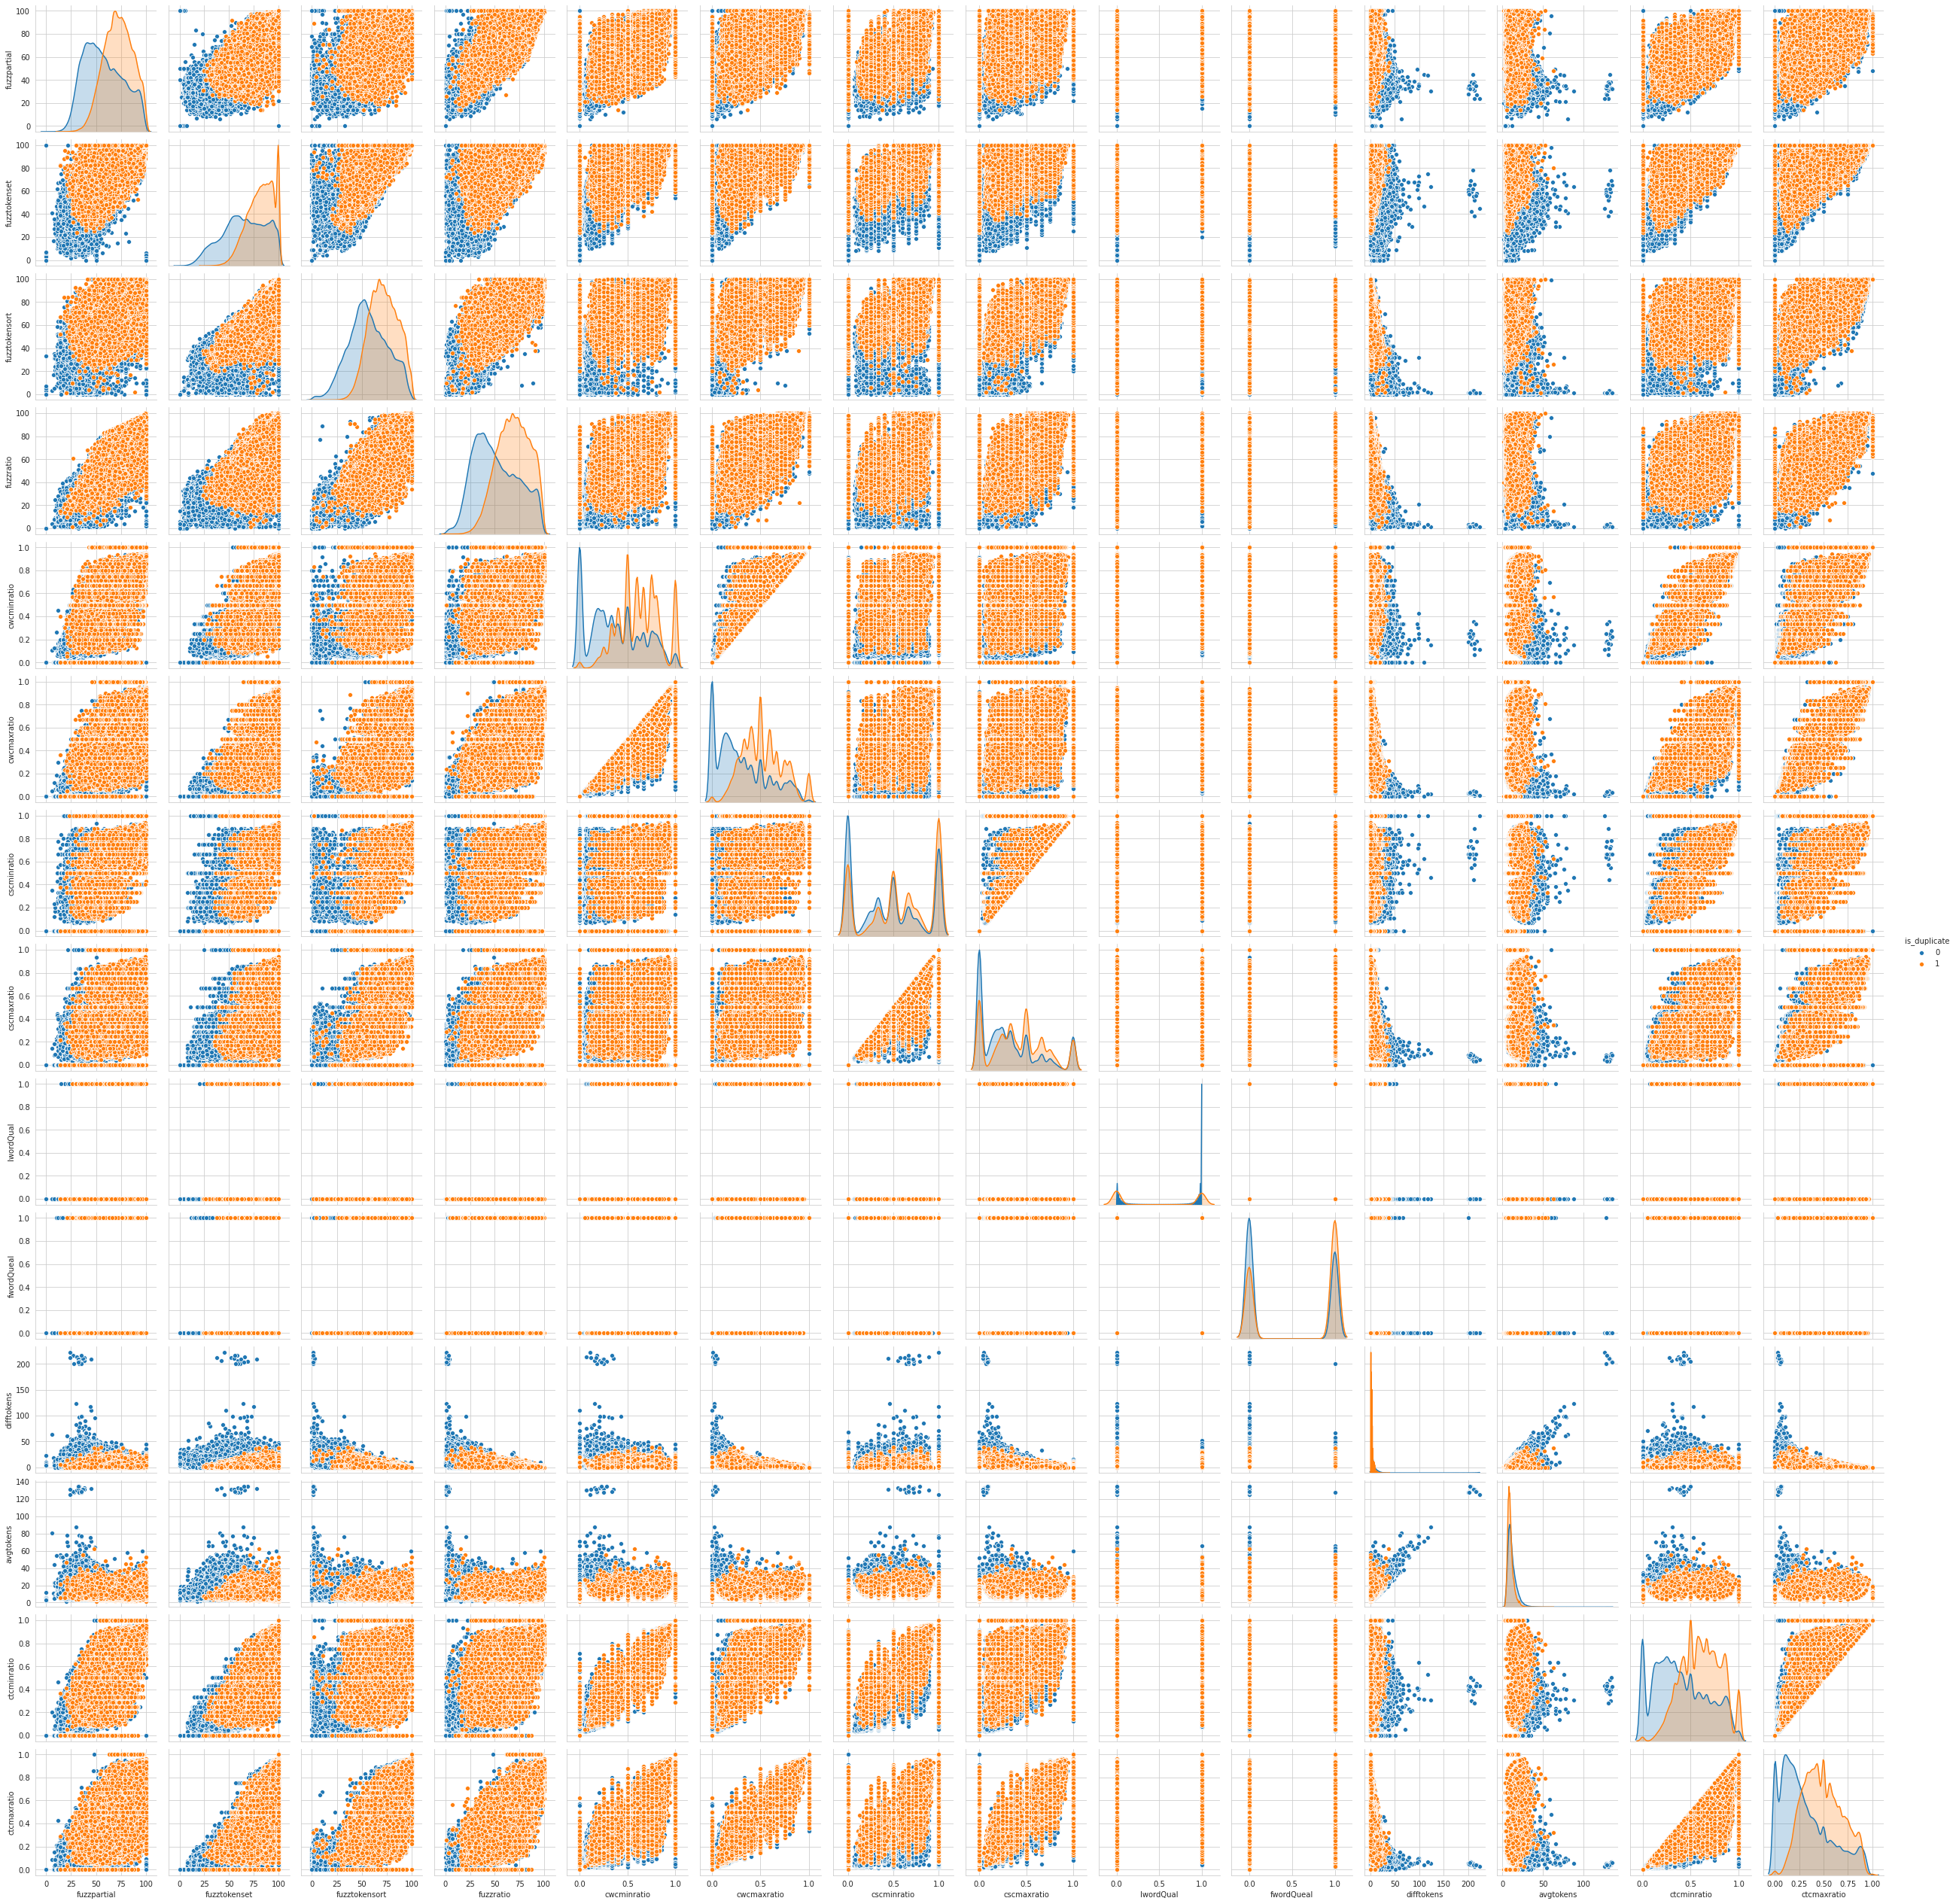

In [0]:
sns.pairplot(data=testingfuzzdf2 , hue='is_duplicate')
plt.show()

* by looking at above pair plots ctcmin,ctcmax,cwcmax,cwcmin,fuzzratio,fuzzsort,fuzztoken,fuzzpartial are usefull than others in our objective of classification

* by looking at their "scatter and pdf" plots we can see there is some amount of seperation which is an not superb but it is noticable.


* lets Perform TSNE on these all new features 

<h4>3.2.4 TSNE on all new features<h4>

In [0]:
tsne_df_withnewfeatures=df[['no_words_in_question1',
       'no_words_in_question2', 'len_of_question1', 'len_of_question2',
       'commonUniqueWords_inBothQuestions', 'frequency_of_question1',
       'frequency_of_question2', 'wordshare', 'fq1+fq2', 'fq1-fq2',
       'total_no_of_words_q1+q2', 'fuzzpartial', 'fuzztokenset',
       'fuzztokensort', 'fuzzratio', 'cwcminratio', 'cwcmaxratio',
       'cscminratio', 'cscmaxratio', 'lwordQual', 'fwordQueal', 'difftokens',
       'avgtokens', 'ctcminratio', 'ctcmaxratio']]

In [0]:
classLabel=df['is_duplicate']

In [0]:
# Standardization 
standard_scalar=StandardScaler()

In [0]:
datascaled=standard_scalar.fit_transform(tsne_df_withnewfeatures)

In [0]:
datascaled.shape

(404290, 25)

In [0]:
datascaled_1000=datascaled[0:5000 , : ]

In [0]:
classLabel_1000=classLabel[0:5000]

In [0]:
tsne=TSNE(n_components=2, perplexity=30.0,  n_iter=1000, init='random', verbose=0, method='barnes_hut', angle=0.5, n_jobs=-1)

In [0]:
tsnedata=tsne.fit_transform(datascaled_1000)

In [0]:
tsnedata=tsnedata.T
df_data_tsnedata=np.vstack((tsnedata,classLabel_1000))

In [0]:
df_data_tsnedata=df_data_tsnedata.T

In [0]:
df_data_tsnedata.shape

(5000, 3)

In [0]:
df_tsne=pd.DataFrame(df_data_tsnedata , columns=('dim1','dim2','label'))

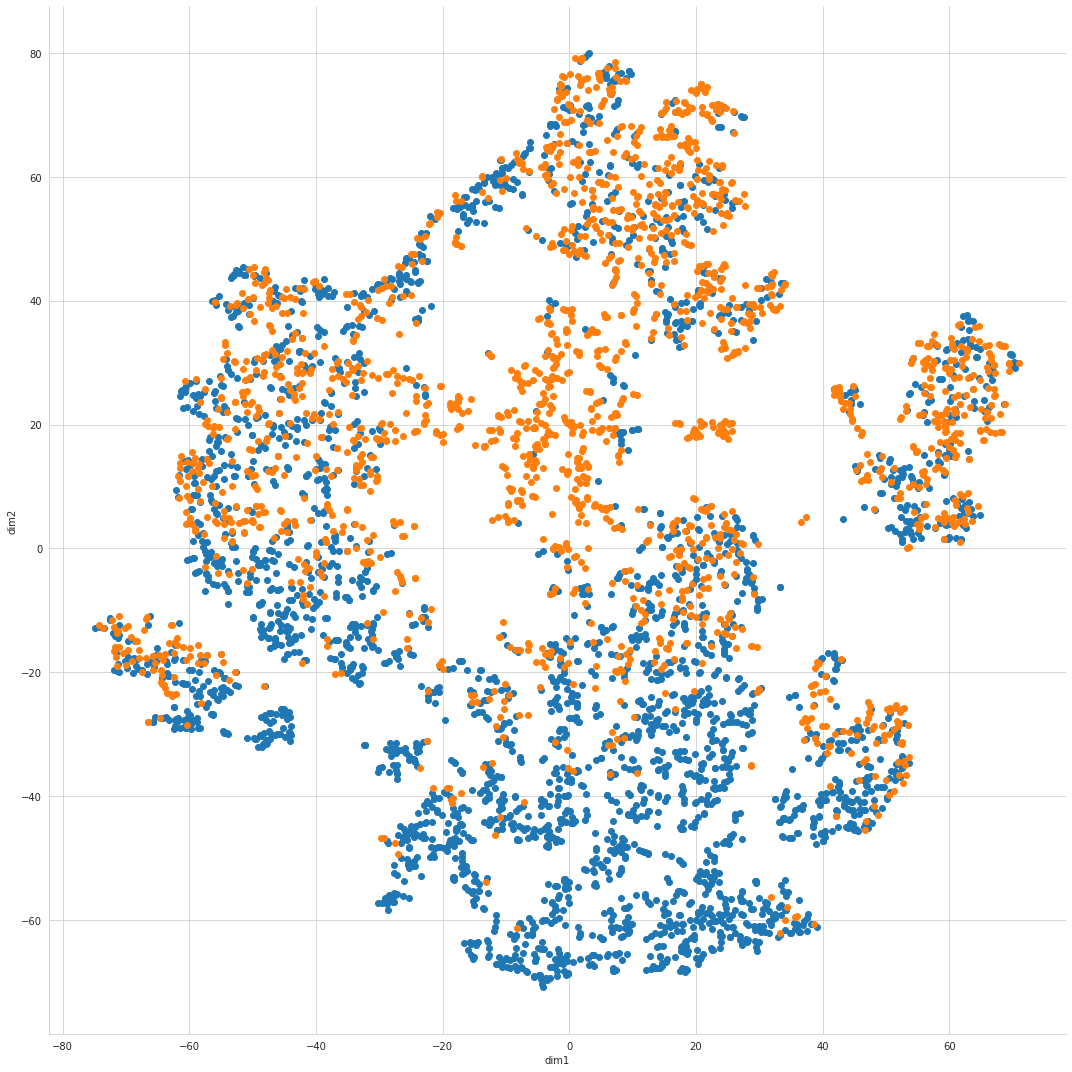

In [0]:
sns.FacetGrid(data=df_tsne , hue= 'label' , height = 15)\
    .map(plt.scatter , 'dim1' , 'dim2')
    
plt.show()    

* As we can see certainly these features are help ful to some extent in our classification task.
* We are able to distinguish between blue class and orange class
by some extent as we took only 5k features.

* lets go to the next phase of data cleaning and converting our text data in to vectors 

<h2> 4. Data Cleaning<h2>


In [0]:
df.head()

id  qid1  qid2  ... avgtokens ctcminratio  ctcmaxratio
0   0     1     2  ...      13.0    0.833326     0.714281
1   1     3     4  ...      10.5    0.499994     0.307690
2   2     5     6  ...      12.0    0.299997     0.214284
3   3     7     8  ...      10.0    0.000000     0.000000
4   4     9    10  ...      10.0    0.285710     0.153845

[5 rows x 31 columns]

* If we observe we have questions in text format to be cleaned and should be converted to machine readable form , to create a model.Lets clean the data now.

In [0]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
cleaned_data_question1=[]

for sentance in df['question1'].values:
  #1.Removing Urls
  sentance=re.sub(r"http\S+" , "" , sentance )
  #2.Removing html tags
  sentance=re.sub(r"<[^<]+?>", "" , sentance )
  #Removing lmxl
  soup = BeautifulSoup(sentance, 'lxml')
  sentance = soup.get_text()
  #3.decontracting phares
  sentance=decontracted(sentance)
  #4.Removing word with numbers
  sentance=re.sub("S*\d\S*" , "" , sentance)
  #5.remove Special charactor punc spaces
  sentance=re.sub(r"\W+", " ", sentance)
  sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in STOPWORDS)
  cleaned_data_question1.append(sentance.strip())




/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning:

"b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.



In [0]:
cleaned_data_question2=[]

for sentance in df['question1'].values:
  #1.Removing Urls
  sentance=re.sub(r"http\S+" , "" , sentance )
  #2.Removing html tags
  sentance=re.sub(r"<[^<]+?>", "" , sentance )
  #3.decontracting phares
  sentance=decontracted(sentance)
  #4.Removing word with numbers
  sentance=re.sub("S*\d\S*" , "" , sentance)
  #5.remove Special charactor punc spaces
  sentance=re.sub(r"\W+", " ", sentance)
  sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in STOPWORDS)
  cleaned_data_question2.append(sentance.strip())




In [0]:
df['question1_cleaned']=pd.DataFrame(cleaned_data_question1)
df['question2_cleaned']=pd.DataFrame(cleaned_data_question2)

In [0]:
df['question2_cleaned'].isna().any()

False

In [0]:
df.isna().any()

id                                   False
qid1                                 False
qid2                                 False
question1                            False
question2                            False
is_duplicate                         False
no_words_in_question1                False
no_words_in_question2                False
len_of_question1                     False
len_of_question2                     False
commonUniqueWords_inBothQuestions    False
frequency_of_question1               False
frequency_of_question2               False
wordshare                            False
fq1+fq2                              False
fq1-fq2                              False
total_no_of_words_q1+q2              False
fuzzpartial                          False
fuzztokenset                         False
fuzztokensort                        False
fuzzratio                            False
cwcminratio                          False
cwcmaxratio                          False
cscminratio

In [0]:
#as we have cleaned questions we can drop these original questions
df=df.drop(columns=['question1','question2'])

In [0]:
df.isna().any()

id                                   False
qid1                                 False
qid2                                 False
is_duplicate                         False
no_words_in_question1                False
no_words_in_question2                False
len_of_question1                     False
len_of_question2                     False
commonUniqueWords_inBothQuestions    False
frequency_of_question1               False
frequency_of_question2               False
wordshare                            False
fq1+fq2                              False
fq1-fq2                              False
total_no_of_words_q1+q2              False
fuzzpartial                          False
fuzztokenset                         False
fuzztokensort                        False
fuzzratio                            False
cwcminratio                          False
cwcmaxratio                          False
cscminratio                          False
cscmaxratio                          False
lwordQual  

<p>
As we have now cleaned text lets create vectors for it 
<p>

<h2>4.1 Featurization<h2>


* taking 75k points due to memory issues.

In [0]:
df_75k_datapoints=df.iloc[ 0:75000 , : ]

In [0]:
df_75k_datapoints.isna().any()

id                                   False
qid1                                 False
qid2                                 False
is_duplicate                         False
no_words_in_question1                False
no_words_in_question2                False
len_of_question1                     False
len_of_question2                     False
commonUniqueWords_inBothQuestions    False
frequency_of_question1               False
frequency_of_question2               False
wordshare                            False
fq1+fq2                              False
fq1-fq2                              False
total_no_of_words_q1+q2              False
fuzzpartial                          False
fuzztokenset                         False
fuzztokensort                        False
fuzzratio                            False
cwcminratio                          False
cwcmaxratio                          False
cscminratio                          False
cscmaxratio                          False
lwordQual  

In [0]:
df_75k_datapoints.head()

id  ...                                  question2_cleaned
0   0  ...          step step guide invest share market india
1   1  ...                    story kohinoor koh noor diamond
2   2  ...       increase speed internet connection using vpn
3   3  ...                              mentally lonely solve
4   4  ...  one dissolve water quikly sugar salt methane c...

[5 rows x 31 columns]

* Using TFIDF featurization 

In [0]:
df_tfidf_q1=pd.DataFrame(df_75k_datapoints['question1_cleaned'])

In [0]:
df_tfidf_q2=pd.DataFrame(df_75k_datapoints['question2_cleaned'])

In [0]:
df_tfidf_q1[df_tfidf_q1.isna().any(1)]

Empty DataFrame
Columns: [question1_cleaned]
Index: []

In [0]:
df_tfidf_q2[df_tfidf_q2.isna().any(1)]

Empty DataFrame
Columns: [question2_cleaned]
Index: []

In [0]:
vectorizer=TfidfVectorizer(ngram_range=(1,2), min_df=10 , max_features = 5000 )

In [0]:
data_Q1_vector=vectorizer.fit_transform(df_tfidf_q1['question1_cleaned'])

In [0]:
data_narray_1=data_Q1_vector.toarray()

In [0]:
df_q1_vector_pd=pd.DataFrame(data_narray_1)

In [0]:
df_q1_vector_pd.to_csv('dataframe_of_q1_vectors_75kand5kFeatures.csv')

In [0]:
data_Q2_vector=vectorizer.fit_transform(df_tfidf_q2['question2_cleaned'])

In [0]:
data_narray_2=data_Q2_vector.toarray()

In [0]:
df_q2_vector_pd=pd.DataFrame(data_narray_2)

In [0]:
df_q2_vector_pd.to_csv('dataframe_of_q2_vectors_75kand5kFeatures.csv')

In [0]:
print(df_q2_vector_pd.shape)
print(df_q1_vector_pd.shape)

(75000, 5000)
(75000, 5000)


In [0]:
df_q1_vector_pd.head()

0     1     2     3     4     5     ...  4994  4995  4996  4997  4998  4999
0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
1   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
2   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
4   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 5000 columns]

In [0]:
df_q2_vector_pd.head()

0     1     2     3     4     5     ...  4994  4995  4996  4997  4998  4999
0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
1   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
2   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
4   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 5000 columns]

* Lets combine this dataframes and original data frame.

In [0]:
# Reading the file
df_75k_datapoints = pd.read_csv ( '/content/df_100k_datapoints_with_allfeaturesexcptq1andq1tfidf.csv')

In [0]:
# Reading the file 
df_q1_vector_pd = pd.read_csv('/content/dataframe_of_q1_vectors_75kand5kFeatures.csv')

In [0]:
# Reading the file
df_q2_vector_pd = pd.read_csv('/content/dataframe_of_q1_vectors_75kand5kFeatures.csv')

In [0]:
combined_dataFrameOf_q1nq2=pd.concat([df_q1_vector_pd,df_q2_vector_pd]  , axis=1)

In [0]:
# Saving the df to csv file
combined_dataFrameOf_q1nq2.to_csv('combined_df_q1q2_75kand5k.csv')

In [0]:
combined_dataFrameOf_q1nq2.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999],
           dtype='int64', length=10000)

In [0]:
# combining the original df and df of q1 n q2
final_data_frame_with_allFeatures=pd.concat([df_75k_datapoints,combined_dataFrameOf_q1nq2],axis=1)

In [0]:
# Saving the df to csv file 
final_data_frame_with_allFeatures.to_csv('FinalDataFrameWith75kdatapointsand10035.csv')

In [0]:
final_data_frame_with_allFeatures.shape

(75000, 10031)

In [0]:
# Reading the file
final_data_frame_with_allFeatures=pd.read_csv("/content/FinalDataFrameWith75kdatapointsand10035.csv")

In [0]:
final_data_frame_with_allFeatures.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'is_duplicate',
       'no_words_in_question1', 'no_words_in_question2', 'len_of_question1',
       'len_of_question2', 'commonUniqueWords_inBothQuestions',
       ...
       '4990.1', '4991.1', '4992.1', '4993.1', '4994.1', '4995.1', '4996.1',
       '4997.1', '4998.1', '4999.1'],
      dtype='object', length=10032)

In [0]:
remove_df=final_data_frame_with_allFeatures

In [0]:
final_data_75kn5k=final_data_frame_with_allFeatures

In [0]:
remove_df=remove_df.drop(columns=['0','qid1','qid2','id','0.1','question1_cleaned','question2_cleaned'])

In [0]:
remove_df=remove_df.drop(columns='Unnamed: 0' ,axis=0)

In [0]:
remove_df.head()

is_duplicate  no_words_in_question1  ...  4998.1  4999.1
0             0                     14  ...     0.0     0.0
1             0                      8  ...     0.0     0.0
2             0                     14  ...     0.0     0.0
3             0                     11  ...     0.0     0.0
4             0                     13  ...     0.0     0.0

[5 rows x 10024 columns]

In [0]:
Final_data_frame_Complete=remove_df

In [0]:
Final_data_frame_Complete.head()

is_duplicate  no_words_in_question1  ...  4998.1  4999.1
0             0                     14  ...     0.0     0.0
1             0                      8  ...     0.0     0.0
2             0                     14  ...     0.0     0.0
3             0                     11  ...     0.0     0.0
4             0                     13  ...     0.0     0.0

[5 rows x 10024 columns]

In [0]:
# writing to csv file
Final_data_frame_Complete.to_csv("completed75kand1024Features.csv")

In [0]:
Final_data_frame_Complete.shape

(75000, 10024)

In [0]:
import pandas as pd

In [0]:
#Reading the csv file
Final_data_frame_Complete= pd.read_csv('/content/completed75kand1024Features.csv')

In [0]:
Final_data_frame_Complete=Final_data_frame_Complete.drop(columns='Unnamed: 0' )

In [0]:
Final_data_frame_Complete.to_csv('Final.csv')

* As we have our final dataframe for modeling lets create models.

<h4> 4.2 Data Spliting <h4>

In [0]:
backup_complete=Final_data_frame_Complete

In [0]:
Final_data_frame_Complete.columns

Index(['is_duplicate', 'no_words_in_question1', 'no_words_in_question2',
       'len_of_question1', 'len_of_question2',
       'commonUniqueWords_inBothQuestions', 'frequency_of_question1',
       'frequency_of_question2', 'wordshare', 'fq1+fq2',
       ...
       '4990.1', '4991.1', '4992.1', '4993.1', '4994.1', '4995.1', '4996.1',
       '4997.1', '4998.1', '4999.1'],
      dtype='object', length=10024)

In [0]:
y=Final_data_frame_Complete['is_duplicate']

In [0]:
type(y)

pandas.core.series.Series

In [0]:
#DependentVariable
y.shape

(75000,)

In [0]:
#Independent Variable  ( features represented as vectors )
X=backup_complete.drop(columns='is_duplicate')

In [0]:
X.head()

no_words_in_question1  no_words_in_question2  ...  4998.1  4999.1
0                     14                     12  ...     0.0     0.0
1                      8                     13  ...     0.0     0.0
2                     14                     10  ...     0.0     0.0
3                     11                      9  ...     0.0     0.0
4                     13                      7  ...     0.0     0.0

[5 rows x 10023 columns]

In [0]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

* As we have our X and y Lets split them accordingly and create CV test and train datasets

In [0]:
X.to_csv('XFinal.csv')
y.to_csv('y(1).csv')

In [0]:
#Loading the X and y for modeling

In [0]:
X=pd.read_csv("/content/drive/My Drive/XFinal.csv")


In [0]:
y=pd.read_csv("/content/y(1).csv")

In [0]:
y=y['is_duplicate'].values

In [0]:
X=X.drop(columns='Unnamed: 0')

In [0]:
X.head()

no_words_in_question1  no_words_in_question2  ...  4998.1  4999.1
0                     14                     12  ...     0.0     0.0
1                      8                     13  ...     0.0     0.0
2                     14                     10  ...     0.0     0.0
3                     11                      9  ...     0.0     0.0
4                     13                      7  ...     0.0     0.0

[5 rows x 10023 columns]

In [0]:
X_train,x_test,y_train,y_test=train_test_split(X,y, stratify=y, test_size=0.2)

In [0]:
X_train,x_cv,y_train,y_cv=train_test_split(X_train,y_train, stratify=y_train , test_size=0.2)

* As we have split the data to for our modelling lets see the size.

In [0]:
print ( X_train.shape,y_train.shape)
print( x_cv.shape,y_cv.shape)
print(x_test.shape,y_test.shape)

(48000, 10023) (48000,)
(12000, 10023) (12000,)
(15000, 10023) (15000,)


* Now we have to perform modeling, We can create a dummy model and compare our model metric with its .. and our choosen metric was logloss.

In [0]:
# dummy model log loss

length_y=len(y)

In [0]:
my_array=np.zeros((length_y,2))
print(my_array.shape)

(75000, 2)


In [0]:
my_array

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [0]:

for row in range(len(y_test)):
  random_element=np.random.rand(1,2)
  my_array[row] = (random_element/np.sum(random_element))[0]



In [0]:
predicted_y=(np.argmax(my_array , axis=1))

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

 the log loss of random model is : 13.739114904950291 


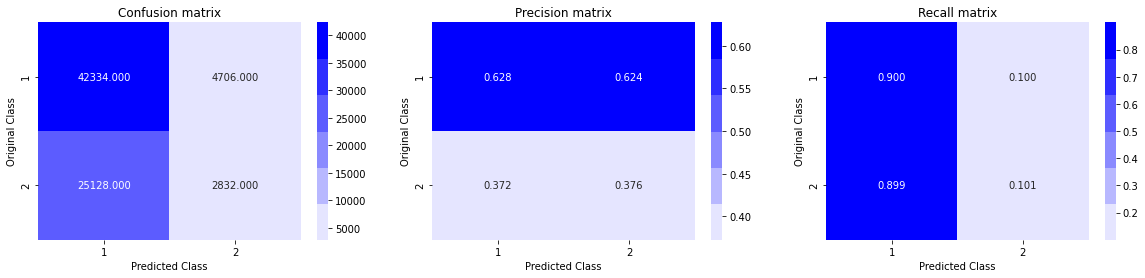

 the confusion metrix , precission matrix and recall matrix is: 


In [0]:
print(" the log loss of random model is : {} ".format( log_loss(y,predicted_y)))

print(" the confusion metrix , precission matrix and recall matrix is: " .format( plot_confusion_matrix(y,predicted_y)))

* We will take this as as the worst case scenario and build our models such that we get logloss lessthan random model.And good confusion metrics scores.

<h2> 4.3 Linear SVM algorithm <h2>

* As we have data lets do hypertuning to find best parameters

In [0]:
alpha= [ 10**x for x in range(-5,2)]
print(alpha)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


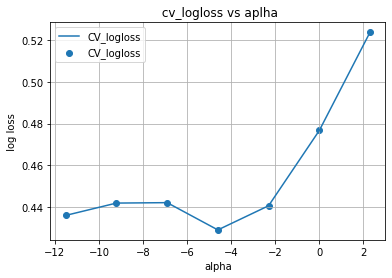

In [0]:
logLos=[ ]

for i in  alpha:

  model=SGDClassifier(loss='hinge',penalty='l2',alpha=i, n_jobs=-1 , class_weight = 'balanced')
  sig_clf = CalibratedClassifierCV(model, method="sigmoid")
  sig_clf.fit(X_train, y_train)

  pred_prob=sig_clf.predict_proba(x_cv) [ : , 1]

  logLos.append( log_loss( y_cv , pred_prob) )
 


plt.plot(np.log(alpha) , logLos  , label = 'CV_logloss')
plt.scatter(np.log(alpha) , logLos , label = 'CV_logloss' )
plt.xlabel('alpha')
plt.ylabel(" log loss ")
plt.grid('white')
plt.legend()
plt.title(" cv_logloss vs aplha")
plt.show()


* We can refer that from the figure the log loss is less for aplha = 0.01

In [0]:
best_aplha_index=  np.argmin(np.array(logLos))
best_alpha=alpha[best_aplha_index]

In [0]:
print( " the minimum Logg loss is for aplha {} and its corresponding loss loss is {} :".format( best_alpha,min(logLos)))

 the minimum Logg loss is for aplha 0.01 and its corresponding loss loss is 0.42914430047414576 :


* Lets Test on the test data and plot confusion matrix and log loss and other metrics

The log loss for this aplha = 0.01 is 0.43185663791842827
************************************************************


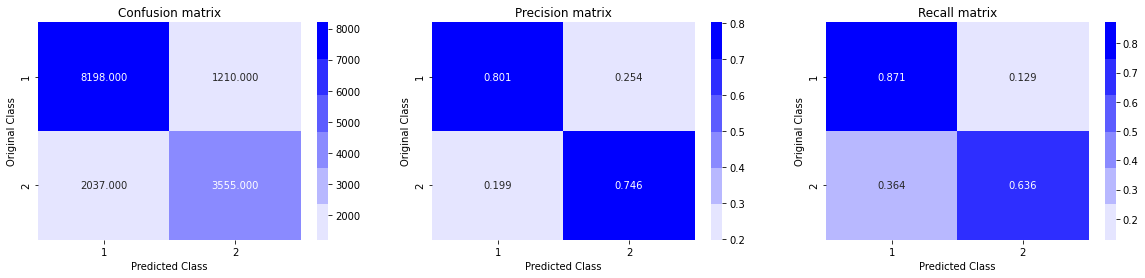

In [0]:
model=SGDClassifier(loss = 'hinge' , penalty = 'l2',alpha= best_alpha , n_jobs=-1 , class_weight= 'balanced')
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(X_train, y_train)
predicted_y= sig_clf.predict_proba(x_test)[: , 1]
print("The log loss for this aplha = 0.01 is {}".format(log_loss(y_test,predicted_y)))
#******************************************************************
print("************************************************************")
y_predicted_test=sig_clf.predict_proba(x_test)
y_pred_test=np.argmax(y_predicted_test , axis=1)
plot_confusion_matrix(y_test,y_pred_test)


* Observations from the above:-
- Log loss is 0.4318 when compared to random model it is way better
- TNR , TPR , FPR , FNR  := 80.1 , 74.7 , 19.7 ,25.1
- Precission and Recall also looking good.

<h3> 4.3 Logistic Regression  Algorithm<h3>


* Lets Hyperparameter tune to fine best alpha 

In [0]:
alpha= [ 10**x for x in range(-5,2)]
print(alpha)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


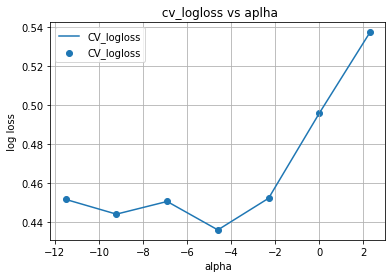

In [0]:
logLos=[ ]

for i in  alpha:

  model=SGDClassifier(loss='log',penalty='l2',alpha=i, n_jobs=-1 , class_weight = 'balanced')
  sig_clf = CalibratedClassifierCV(model, method="sigmoid")
  sig_clf.fit(X_train, y_train)

  pred_prob=sig_clf.predict_proba(x_cv) [ : , 1]

  logLos.append( log_loss( y_cv , pred_prob) )
 


plt.plot(np.log(alpha) , logLos  , label = 'CV_logloss')
plt.scatter(np.log(alpha) , logLos , label = 'CV_logloss' )
plt.xlabel('alpha')
plt.ylabel(" log loss ")
plt.grid('white')
plt.legend()
plt.title(" cv_logloss vs aplha")
plt.show()


In [0]:
best_aplha_index=  np.argmin(np.array(logLos))
best_alpha=alpha[best_aplha_index]

In [0]:
print( " the minimum Logg loss is for aplha {} and its corresponding loss loss is {} :".format( best_alpha,min(logLos)))

 the minimum Logg loss is for aplha 0.01 and its corresponding loss loss is 0.4359580380874459 :


The log loss for this aplha = 0.01 is 0.42867104563430924
************************************************************


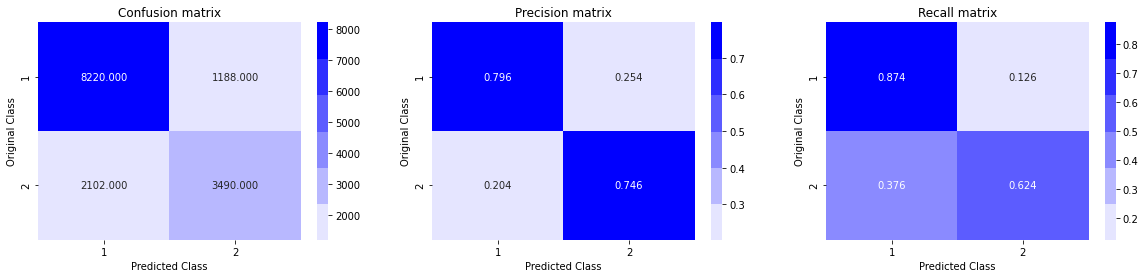

In [0]:
model=SGDClassifier(loss = 'log' , penalty = 'l2',alpha= best_alpha , n_jobs=-1 , class_weight= 'balanced')
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(X_train, y_train)
predicted_y= sig_clf.predict_proba(x_test)[: , 1]
print("The log loss for this aplha = 0.01 is {}".format(log_loss(y_test,predicted_y)))
#******************************************************************
print("************************************************************")
y_predicted_test=sig_clf.predict_proba(x_test)
y_pred_test=np.argmax(y_predicted_test , axis=1)
plot_confusion_matrix(y_test,y_pred_test)


* Observations from the above:-
- Log loss is 0.4286 when compared to random model it is way better
- TNR , TPR , FPR , FNR  := 79.6 , 74.6 , 20.3 ,25.3
- Precission and Recall also looking good.

<h1>5.0 Results <h1>


* using pretty table library

In [0]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ["Vectorizer","classifier used","Hyper Parameter",  "LogLoss"]
table.add_row(["array","random Model","null",13])
table.add_row(["TFIDF","LogisticRegression",0.01,0.4286])
table.add_row(["TFIDF","Linear SVM",0.01,0.4318])
print(table)


+------------+--------------------+-----------------+---------+
| Vectorizer |  classifier used   | Hyper Parameter | LogLoss |
+------------+--------------------+-----------------+---------+
|   array    |    random Model    |       null      |    13   |
|   TFIDF    | LogisticRegression |       0.01      |  0.4286 |
|   TFIDF    |     Linear SVM     |       0.01      |  0.4318 |
+------------+--------------------+-----------------+---------+


* We can notice logistic regresion performed better than all we can infer from the result table.Linear SVM also performed Good.